## 3.Project/homework

Multiclass and one-vs-all.

In chapter 1 we've created a multiclass classifier for MNIST dataset. Please create a classifier with a strategy known as one-vs-all.
It means you should create 10 separate classifiers, each for a single class.

Build and train the smallest possible (by the number of trainable weights) classifiers with an F1 (macro) score at 0.97 level.

Compare the number of total weights for 10 classifiers one-vs-all and 1 multi-classifier.

**This homework is obligatory. Please send colab link to kwant@agh.edu.pl before 08.05.2024.**

In [1]:
!wget -nc https://raw.githubusercontent.com/MenosGrandes/AI_ML_Course/main/requirements.txt


File ‘requirements.txt’ already there; not retrieving.



In [2]:
!pip install -r requirements.txt
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
import pandas as pd
import numpy as np
import platform
import pandas as pd
import numpy as np
import warnings
import sys;
#define Seaborn color palette to use
import numpy as np
from math import ceil
from itertools import zip_longest
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
import missingno as msno
import re
import tensorflow as tf
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np





2024-04-30 11:17:44.635702: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 11:17:44.636081: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 11:17:44.638472: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 11:17:44.665675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 11:17:45.208036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:

import logging
from rich.logging import RichHandler

FORMAT = "%(message)s"
logging.basicConfig(
    level="NOTSET", format=FORMAT, datefmt="[%X]", handlers=[RichHandler()]
)

logger = logging.getLogger("rich")


In [4]:
v = platform.python_version_tuple();
if float(v[1]) < 10:
    raise Exception("MUST USE Python 3.10 to use MATCH expression!")

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_colwidth = 1000

In [5]:

# import MNIST dataset
(x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255       # 784 = 28*28
x_valid = x_valid.reshape(10000, 784).astype('float32') / 255

logger.info('x_train size: ' + str(x_train.shape))

[11:17:45] INFO     x_train size: (60000, 784)                                                      ]8;id=396625;file:///tmp/ipykernel_56820/1544249798.py\1544249798.py]8;;\:]8;id=215986;file:///tmp/ipykernel_56820/1544249798.py#6\6]8;;\

In [6]:
#@title Display MNIST data
def plot_mnist(images, labels):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8), sharex='col', sharey='row')
    for x in range(4):
        for y in range(4):
            idx = random.randint(0, images.shape[0]-1)
            img = images[idx].reshape(28, 28)
            truth = labels[idx]
            ax[x,y].imshow(img, cmap='gray')
            ax[x,y].set_title(str(truth))



In [7]:
# Hyperparameters!
from typing import NamedTuple
class HyperParameters(NamedTuple):
    droputs : float
    output_layers : int
    epochs :int
    bach_size : int
    input_dim :int


In [8]:
class ModelWrapper:
    def __init__(self,name, model,x_valid,y_valid,hyperparams):
        self.__model = model;
        self.__x_valid = x_valid
        self.__y_valid = y_valid
        self.__name = name
        self.__hyperparameters = hyperparams;
        self.__pred()
        self.__is_fit = False;
        
    def __pred(self):
        self.__y_valid_pred = np.argmax(self.__model.predict(self.__x_valid), axis=1)

    def plot_confusion_matrix(self):
        _cm = confusion_matrix(self.__y_valid, self.__y_valid_pred)
        _cmp = ConfusionMatrixDisplay(confusion_matrix=_cm,
                                      display_labels=list(range(10)))
        _fig, _ax = plt.subplots(figsize=(8, 8))
        _cmp.plot(ax=_ax)
        _fig.show()        

    def plot_overfitting(self):
        plt.figure(figsize=(13, 5))
        plt.plot(self.__history.history['accuracy'])
        plt.plot(self.__history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(['Train','Test'])
        plt.grid()
        plt.show()

    def summarise(self):
        if self.__is_fit is True:
            self.__pred()
            logger.info(f'{self.__name} | Model summary:\n')
            self.__model.summary()
            logger.info(f'{self.__name} | Classification report: \n')
            self.__pred()
            logger.info(f'{classification_report(self.__y_valid, self.__y_valid_pred)}')

            self.plot_confusion_matrix()
            self.plot_overfitting()
        else:
            logger.error(f"You should fit model first!")
            
    def fit(self,_x_train, _y_train):
        logger.info(f'{self.__name} | Model fitting!')

        self.__history = self.__model.fit(_x_train, _y_train,
                    batch_size=self.__hyperparameters.bach_size,
                    epochs=self.__hyperparameters.epochs,
                    validation_data=(self.__x_valid, self.__y_valid),
                    verbose=1)
        self.__is_fit = True
        
        




In [9]:

def build_base_multiclassification_model(hyperparams, name):
    model = tf.keras.Sequential(name=name)
    model.add(Input((hyperparams.input_dim,)))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(hyperparams.droputs))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dropout(hyperparams.droputs))
    model.add(Dense(hyperparams.output_layers, activation = 'softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# History of above cell.
When I have added the droput layet, the accuracy dropped from 98.2% to 97.6, BUT its no longer overfitted ( based on the graph drawed at later cell ), so I think it's a lot better.

In [10]:

base_hyperparams = HyperParameters(droputs = 0.2,output_layers = 10,epochs = 10,bach_size = 16,input_dim =784)

In [11]:
base_model_name = "MultimClassClassificationBaseModel"
multiclassification_base_model = build_base_multiclassification_model(base_hyperparams,base_model_name)


In [12]:
models = []
models.append(ModelWrapper(base_model_name, multiclassification_base_model,x_valid,y_valid, base_hyperparams))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


In [13]:
models[0].fit(x_train,y_train)


[11:17:46] INFO     MultimClassClassificationBaseModel | Model fitting!                             ]8;id=907289;file:///tmp/ipykernel_56820/205719947.py\205719947.py]8;;\:]8;id=351143;file:///tmp/ipykernel_56820/205719947.py#48\48]8;;\

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8322 - loss: 0.5486 - val_accuracy: 0.9586 - val_loss: 0.1361
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9452 - loss: 0.1826 - val_accuracy: 0.9672 - val_loss: 0.1080
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9566 - loss: 0.1439 - val_accuracy: 0.9707 - val_loss: 0.0956
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9638 - loss: 0.1203 - val_accuracy: 0.9736 - val_loss: 0.0885
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9674 - loss: 0.1049 - val_accuracy: 0.9756 - val_loss: 0.0822
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9700 - loss: 0.0984 - val_accuracy: 0.9732 - val_loss: 0.0860
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9706 - loss: 0.0930 - val_accuracy: 0.9762 - val_loss: 0.0808
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9729 - loss: 0.0884 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


[11:18:59] INFO     MultimClassClassificationBaseModel | Model summary:                             ]8;id=925664;file:///tmp/ipykernel_56820/205719947.py\205719947.py]8;;\:]8;id=274532;file:///tmp/ipykernel_56820/205719947.py#36\36]8;;\
                                                                                                                   

Model: "MultimClassClassificationBaseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,182 (985.09 KB)

 Trainable params: 84,060 (328.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 168,122 (656.73 KB)

           INFO     MultimClassClassificationBaseModel | Classification report:                     ]8;id=239733;file:///tmp/ipykernel_56820/205719947.py\205719947.py]8;;\:]8;id=977875;file:///tmp/ipykernel_56820/205719947.py#38\38]8;;\
                                                                                                                   

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


[11:19:00] INFO                   precision    recall  f1-score   support                           ]8;id=658415;file:///tmp/ipykernel_56820/205719947.py\205719947.py]8;;\:]8;id=307092;file:///tmp/ipykernel_56820/205719947.py#40\40]8;;\
                                                                                                                   
                               0       0.98      0.99      0.99       980                                          
                               1       0.99      0.99      0.99      1135                                          
                               2       0.97      0.99      0.98      1032                                          
                               3       0.96      0.98      0.97      1010                                          
                               4       0.98      0.98      0.98       982                                          
                               5       0.98      0.97      0.98       892                                          
                               6       0.98      0.98      0.98       958                                          
                               7       0.98      0.97      0.97      1028                                          
                               8       0.98      0.96      0.97       974                                          
                               9       0.97      0.97      0.97      1009                                          
                                                                                                                   
                        accuracy                           0.98     10000                                          
                       macro avg       0.98      0.98      0.98     10000                                          
                    weighted avg       0.98      0.98      0.98     10000                                          
                                                                                                                   

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f0431fb4040>               ]8;id=717881;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=189800;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_56820/205719947.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


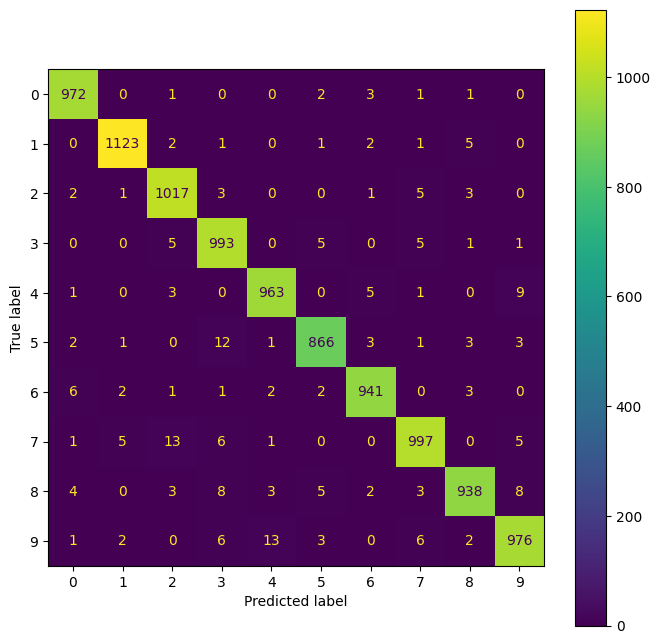

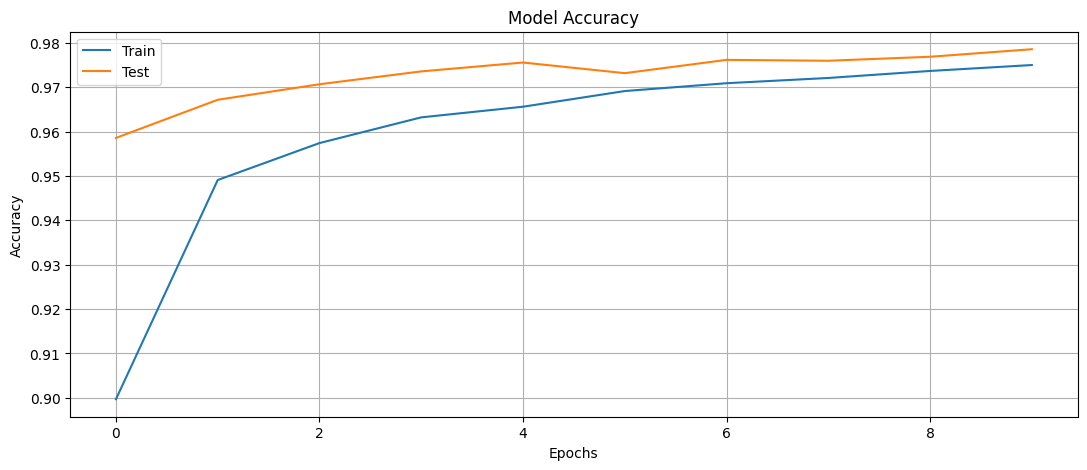

[None]

In [15]:

[x.summarise() for x in models]